In [2]:
import pandas as pd

import numpy as np
import scipy as sp
from scipy import signal
from scipy import ndimage
from scipy.ndimage.morphology import binary_closing
from scipy.optimize import curve_fit
from scipy.misc import imsave
import scipy.io as sio
import scipy.stats as st

import cv2
from PIL import ImageFilter
from PIL import Image
from skimage.filters import threshold_otsu
from skimage.morphology import remove_small_objects
from skimage.measure import regionprops, label, find_contours
from skimage.restoration import unwrap_phase
from skimage.feature import blob_log, canny
from skimage.exposure import equalize_hist

import imageio
import random
import os
import fnmatch
import math
import re

import matplotlib.pyplot as plt
import matplotlib.patches as patches
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter

from keras.datasets import mnist
from bisect import bisect_left

from skimage.feature import peak_local_max

C:\Users\Duo\Anaconda3\envs\fastai\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [3]:
%pylab inline
pylab.rcParams['figure.figsize'] = (20, 10)

Populating the interactive namespace from numpy and matplotlib


C:\Users\Duo\Anaconda3\envs\fastai\lib\site-packages\IPython\core\magics\pylab.py:160: UserWarning: pylab import has clobbered these variables: ['random', 'imsave']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [4]:
image_path = "I:\\Honours-Project\\data\\simulation\\obj\\0d098413-6911-4535-b70a-3c3effd8cf49.png"
image_path = "I:\\Honours-Project\\data\\simulation\\obj\\malaria\\malaria\\images\\0ac747cd-ff32-49bf-bc1a-3e9b7702ce9c.png"
#image_path = "I:\\Honours-Project\\data\\simulation\\obj\\gestalt-theory-wwf-panda-logo.jpg"
#image_path = "I:\\Honours-Project\\data\\simulation\\obj\\00ae65c1c6631ae6f2be1a449902976e6eb8483bf6b0740d00530220832c6d3e.png"
image_path = 'I:\\Honours-Project\\data\\simulation\\obj\\4.TIF'

In [5]:
img = cv2.imread(image_path)
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

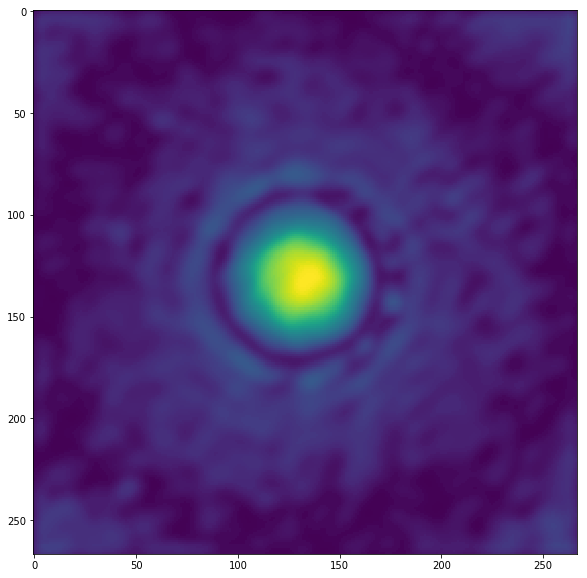

In [6]:
plt.imshow(gray)

In [7]:
def intensity(img):
    return np.power(np.abs(img),2)

In [8]:
# https://stackoverflow.com/questions/12141150/from-list-of-integers-get-number-closest-to-a-given-value
def takeClosest(myList, myNumber):
    """
    Assumes myList is sorted. Returns closest value to myNumber.

    If two numbers are equally close, return the smallest number.
    """
    pos = bisect_left(myList, myNumber)
    if pos == 0:
        before = None
        after = None
    if pos == len(myList):
        before = myList[-1]
        after = None
    before = myList[pos - 1]
    after = myList[pos]
    
    return before, after

In [9]:
noise_mult_neg = -1
noise_mult_pos = 1

class speckle_noise(st.rv_continuous):
    mu = 0.95
    
    def _pdf(self,epsilon):
        b = np.abs(self.mu) * np.cos(epsilon)
        f = (1-np.power(np.abs(self.mu),2))/(2*np.pi)
        g = np.power(1-np.power(b,2),(-3/2))
        h = (b * np.arcsin(b))+((np.pi*b)/2) + np.power(1-np.power(b,2),(1/2))

        return f*g*h
    
    def rvs(self,size):
        res = []
        pdf = self._pdf(0)
    
        
        while len(res) < size:
            uni = np.random.uniform(self.a,self.b) # Since the function is mirrored around 0
            sam = np.random.uniform(0,pdf)
                    
            pdf_val = self._pdf(uni)
            if sam < pdf_val:
                res.append(uni)

        return np.array(res)

#noise_dist = speckle_noise(a=-5*math.pi, b=10*math.pi, name='speckle')
noise_dist = speckle_noise(a=noise_mult_neg*math.pi, b=noise_mult_pos*math.pi, name='speckle')
    
def generate_noise(x,y):
    noise = noise_dist.rvs(size=(x*y))
    noise = noise.reshape((x,y))
    
    return noise

In [10]:
def get_kernel(wavelength,z,dx,dy,x,y,noisy=False):
    kernelFactor = 2*math.pi*z/wavelength
    
    dfx = 1/(dx*x)
    dfy = 1/(dy*y)
    
    # Count up then down eg: [0,1,2,1,0]
    if x % 2 == 0:
        x2 = np.append(np.arange(x/2),np.flip(np.arange(x/2)))
    else:
        x2 = np.append(np.arange((x/2)-1),[math.ceil(x/2)])
        x2 = np.append(x2,np.flip(np.arange((x/2)-1)))
        
    if y % 2 == 0:
        y2 = np.append(np.arange(y/2),np.flip(np.arange(y/2)))
    else:
        y2 = np.append(np.arange((y/2)-1),[math.ceil(y/2)])
        y2 = np.append(y2,np.flip(np.arange((y/2)-1)))
    
    l = x2 - (x/2) + 1
    l2 = (l**2) * (dfx**2)
    
    m = y2 - (y/2) + 1
    m2 = (m**2) * (dfy**2)
    
    l3 = np.broadcast_to(l2, (y,x)).transpose()
    m3 = np.broadcast_to(m2, (x,y))
    
    kernelPhase = np.power(1 - ((l3+m3) * (wavelength**2)),(1/2)) * kernelFactor
    
    if noisy:
        noise = generate_noise(x,y)
        kernelPhase = kernelPhase + noise
        
    '''print("m3")
    print(m3)
    print("l3")
    print(l3)
    print("phase")
    print(kernelPhase)
            
    plt.imshow(np.angle(np.fft.ifft(np.fft.fftshift(kernelPhase))))'''
    
    real = np.cos(kernelPhase)    
    img = 1j*np.sin(kernelPhase)
    
    return real+img

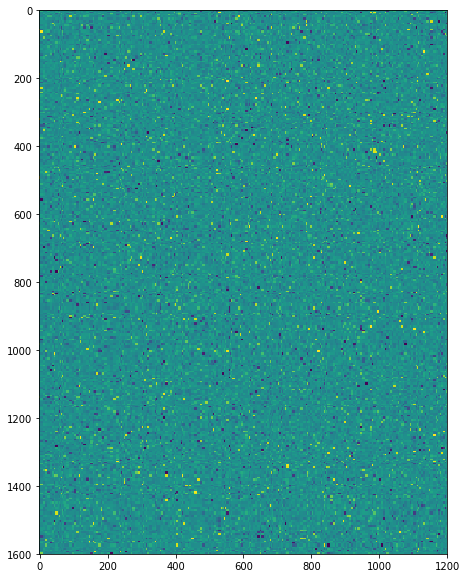

In [11]:
x = 1600
y = 1200
max_speckle_size = 10

def gen_rand_sizes(i):
    sum_i = 0
    list_i = []
    
    while sum_i < (i-1):
        r = random.randint(1,min(max_speckle_size,i-(sum_i-1)))
        list_i.append(r)
        sum_i+=r
        
    return list_i

def gen_noise_random_size(x,y):
    x_list = gen_rand_sizes(x)
    y_list = gen_rand_sizes(y)
    
    noise = noise_dist.rvs(size=(len(x_list)*len(y_list)))
    
    noise_mat = np.zeros((x,y))
    
    current_x = 0
    current_y = 0
    
    noise_counter = 0
    
    for block_x in x_list:
        current_y = 0
        for block_y in y_list:
            noise_mat[current_x:current_x+block_x,current_y:current_y+block_y] = noise[noise_counter]
            current_y += block_y
            noise_counter += 1
        current_x += block_x
            
    return noise_mat
            
plt.imshow(gen_noise_random_size(x,y))


0.3141457634150027


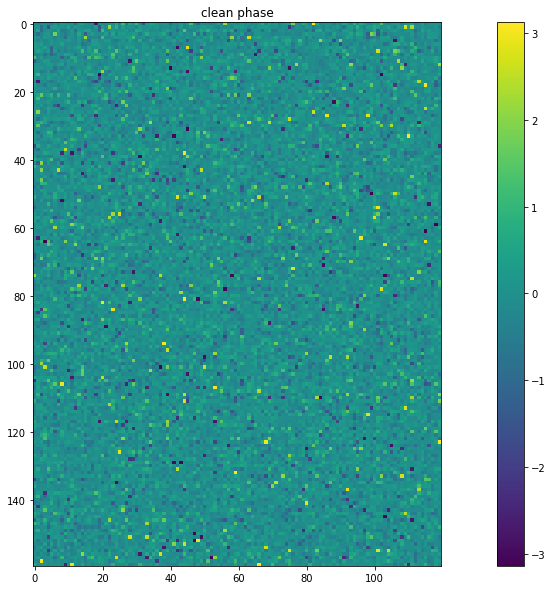

In [12]:
wavelength=0.6328 # - um
z=1.503 # 1.503 # - um
dx=4.24 # - um
dy=4.24 # - um

#k = get_kernel(wavelength,z,dx,dy,160,120,noisy=True)
compress=1
noise = generate_noise(int(160/compress),int(120/compress))
noise = np.repeat(np.repeat(noise,compress,axis=0),compress,axis=1)

#plt.imshow(noise)

fig,ax = plt.subplots(1,1)

ax.set_title("clean phase")
bax = ax.imshow(noise)
bbar = fig.colorbar(bax,ax=ax)

phase = np.cos(noise) + 1j*np.sin(noise)
print(np.mean(np.abs(noise)))

In [13]:
print(1600/compress)
print(compress)

1600.0
1


In [14]:
'''
    img - complex array
    
'''

def angular_spectrum(img,wavelength,z,dx,dy,noisy=None):
    x,y = img.shape

    kernel = get_kernel(wavelength,z,dx,dy,x,y,False)
    fft = np.fft.fft2(img)
    
    s = np.angle(fft)
    
    if noisy is not None:
        s = np.add(noisy,s)
    
    new_fft = np.multiply(np.abs(fft),np.cos(s)+1j*np.sin(s))
    new_fft = np.multiply(kernel,new_fft)
    #fig,ax = plt.subplots(1,1)

    #ax.set_title("S")
    #ax.imshow(np.log(1+np.abs(new_fft)))
    #ax.imshow(s)
    #bbar = fig.colorbar(bax)
    
    #print(np.max(fft-new_fft))
    
    inv = np.fft.ifft2(new_fft)
    
    return inv

In [15]:
'''
    img - intensity image
    wavelength - um
    z - um
    dx - um
    dy - um
'''

def object_propogation(img,wavelength,z,dx,dy,noisy=None):
    return angular_spectrum(img,wavelength,z,dx,dy,noisy)

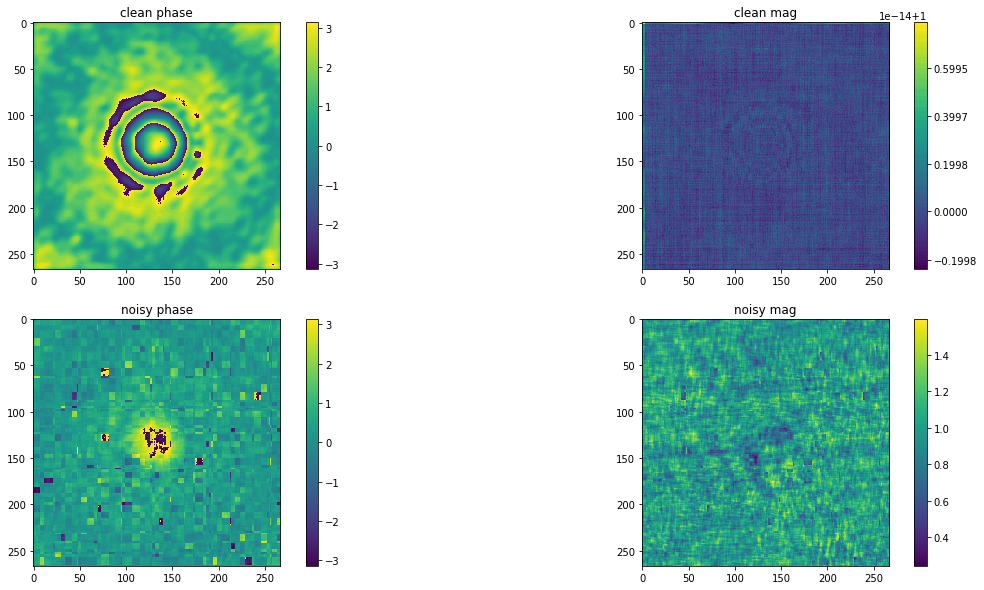

In [16]:
wavelength=0.6328 # - um
z=0 # 1.503 # - um
dx=4.24 # - um
dy=4.24 # - um

a=88.31 # deg
b=88.31 # deg

x, y = gray.shape

noise = gen_noise_random_size(int(x),int(y))

noisy_phase = (gray-np.min(gray))/(np.max(gray)-np.min(gray)) * math.pi + noise
clean_phase = (gray-np.min(gray))/(np.max(gray)-np.min(gray)) *  math.pi * 5

noisy_obj = np.cos(noisy_phase)+1j*np.sin(noisy_phase) # Create object with the same real and imaginary values
clean_obj = np.cos(clean_phase)+1j*np.sin(clean_phase) # Create object with the same real and imaginary values
#obj = np.multiply(phase*2,obj)

#obj = np.ones((x,y)) + 1j*phase

noisy_wave = object_propogation(noisy_obj,wavelength,z,dx,dy,noisy=noise)

clean_wave = object_propogation(clean_obj,wavelength,z,dx,dy,noisy=None)

fig,ax = plt.subplots(2,2)

ax[0][0].set_title("clean phase")
bax = ax[0][0].imshow(np.angle(clean_wave))
bbar = fig.colorbar(bax,ax=ax[0][0])

ax[0][1].set_title("clean mag")
cax = ax[0][1].imshow(np.abs(clean_wave))
cbar = fig.colorbar(cax,ax=ax[0][1])

ax[1][0].set_title("noisy phase")
dax = ax[1][0].imshow(np.angle(noisy_wave))
dbar = fig.colorbar(dax,ax=ax[1][0])

ax[1][1].set_title("noisy mag")
eax = ax[1][1].imshow(np.abs(noisy_wave))
ebar = fig.colorbar(eax,ax=ax[1][1])

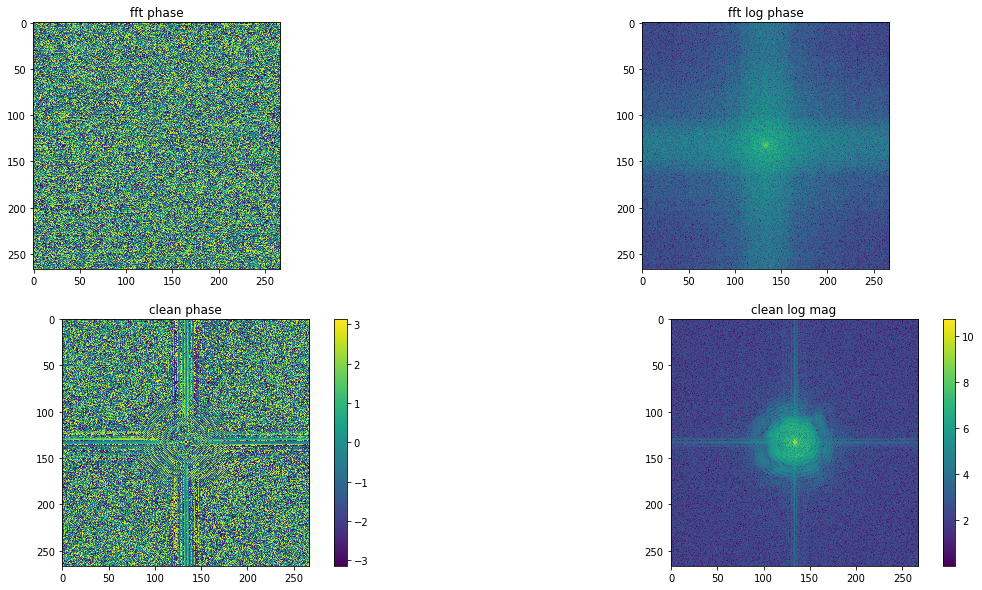

In [17]:
fft = np.fft.fftshift(np.fft.fft2(noisy_wave))#-np.fft.fftshift(np.fft.fft2(clean_wave))
fft_clean = np.fft.fftshift(np.fft.fft2(clean_wave))#-np.fft.fftshift(np.fft.fft2(clean_wave))

fig,ax = plt.subplots(2,2)

ax[0][0].set_title("fft phase")
ax[0][0].imshow(np.angle(fft))

ax[0][1].set_title("fft log phase")
ax[0][1].imshow(np.log(np.abs(fft)+1))

ax[1][0].set_title("clean phase")
dax = ax[1][0].imshow(np.angle(fft_clean))
dbar = fig.colorbar(dax,ax=ax[1][0])

ax[1][1].set_title("clean log mag")
eax = ax[1][1].imshow(np.log(np.abs(fft_clean)+1))
ebar = fig.colorbar(eax,ax=ax[1][1])

In [18]:
'''
   wavelength - um
   dx - um
   dy - um
   a - degree
   b - degree
   x - width of output in px
   y - height of output in px

   return:
   real - cos(phase)
   imag - phase
'''
def gen_plane_wave(wavelength,dx,dy,a,b,x,y,noisy=False):
    alpha=math.cos(a/180*math.pi)
    beta=math.cos(b/180*math.pi)

    if not (1-(alpha**2)-(beta**2) > 0):
        print(alpha**2)
        print(1-(alpha**2)-(beta**2))
        raise ValueError("Insert a valid pair of director angles. Remember that cos^2(a) + cos^2(b) <= 1")

    gamma=math.sqrt(1-(alpha**2)-(beta**2))

    # wavelength=wavelength*0.001 # Convert wavelength to um

    k3 = 3*2*math.pi/wavelength #TODO: Currently assuming lambda is wavelength

    if k3 * alpha * dx > (2*math.pi):
        angle = math.degrees(math.acos((2*math.pi) / (k3 * dx)))

        raise ValueError("In order to fulfill the sampling theorem, the director angle a >= " + str(angle))

    if k3 * beta * dx > (2*math.pi):
        angle = math.degrees(math.acos((2*math.pi) / (k3 * dy)))

        raise ValueError("In order to fulfill the sampling theorem, the director angle b >= " + str(angle))

    k = 2*math.pi / wavelength

    n = k * gamma

    l = (np.arange(x) - (x/2) + 1) * dx * alpha * k
    m = (np.arange(y) - (y/2) + 1) * dy * beta * k

    #l = np.arange(x)
    #m = np.arange(y)
    
    l = np.broadcast_to(l, (y,x)).transpose()
    m = np.broadcast_to(m, (x,y))
    n = np.broadcast_to(n, (x,y))

    phase = l + m + n

    #phase[int(x/2):x,:] = phase[int(x/2):x,:] + 2
    
    plt.imshow(phase)

    wavefront_real = np.cos(phase)
    wavefront_imaginary = np.sin(phase)
    
    # We do this because numerical imperfections cause errors in freq. domain
    wave = wavefront_real + 1j*wavefront_imaginary
    fft = np.fft.fft2(wave)
    
    cropped_fft = fft
    cropped_fft[fft < np.max(fft)] = 0
    
    new_fft = np.fft.ifft2(cropped_fft)

    #return np.real(new_fft), np.imag(new_fft)
    
    return wavefront_real,wavefront_imaginary

(923061.3907998558+1455939.4162652427j)
[[52 69]]
3.1381299167015397
-3.1412502501074853


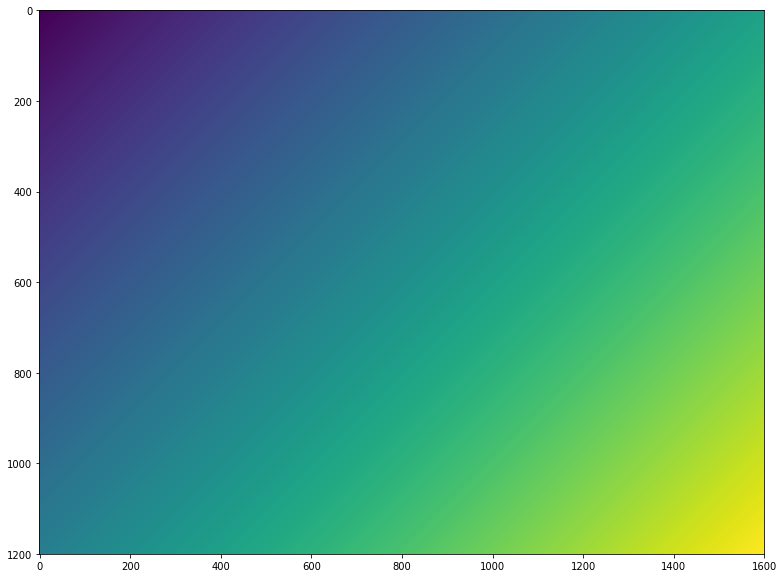

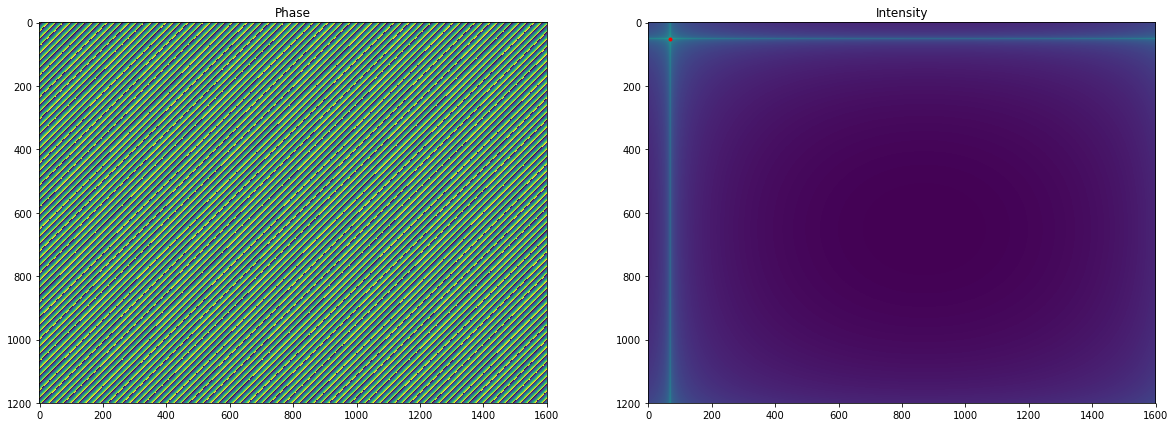

In [19]:
real, imaginary = gen_plane_wave(0.6328,.424,.424,86.31,86.31,1200,1600)
wave = real + 1j*imaginary
fig,ax = plt.subplots(1,2)

fft = np.fft.fft2(wave)
print(np.max(fft))
log_fft = np.log(np.abs(np.fft.fft2(wave)))

coordinates = peak_local_max(np.abs(fft), min_distance=5)

cropped_fft = fft
cropped_fft[fft < np.max(fft)] = 0

ax[0].set_title("Phase")
cax = ax[0].imshow(np.angle(np.fft.ifft2(cropped_fft)))
#cax = ax[0].imshow(np.angle(wave))
#cbar = fig.colorbar(cax)

ax[1].set_title("Intensity")
#bax = ax[1].imshow(np.log(np.abs(np.fft.fftshift(np.fft.fft2(wave))+1)))
bax = ax[1].imshow(log_fft)
ax[1].plot(coordinates[:, 1], coordinates[:, 0], 'r.')
#bbar = fig.colorbar(bax)

print(coordinates)

print(np.max(np.angle(wave)))
print(np.min(np.angle(wave)))

1.0057533208760985
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


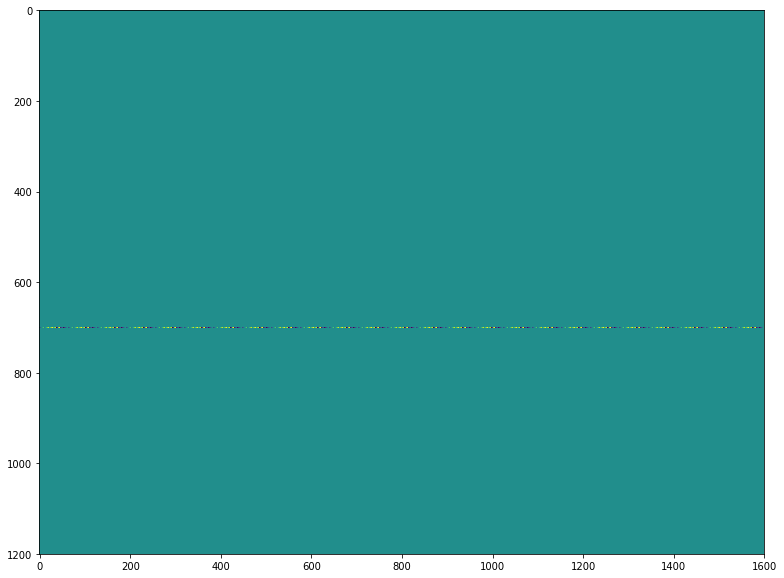

In [20]:
fft = np.zeros((1200,1600)) + 1j*0
fft[100,100] = 923061.3907998558+1455939.4162652427j
fft[1100,1500] = fft[100,100] 

print(np.angle(np.max(fft)))

plt.imshow(np.angle(np.fft.ifft(np.fft.fftshift(fft))))
print(np.angle(np.fft.ifft(np.fft.fftshift(fft))))

In [21]:
sp.misc.imsave('test_phase.png', np.angle(np.fft.ifft2(cropped_fft)))

C:\Users\Duo\Anaconda3\envs\fastai\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.
  """Entry point for launching an IPython kernel.


In [22]:
print(np.max(np.abs(np.fft.ifft2(np.fft.fft2(wave))-wave)))

2.112343365827712e-15


In [23]:
generate_noise(10,10)

array([[ 4.41074107e-02, -3.59124313e-02, -1.02447515e-01,
        -3.63975666e-03, -3.26177486e-01,  2.00949029e-01,
         1.12466190e-01, -9.95745517e-02,  1.06649278e+00,
        -1.17571763e-01],
       [ 2.02305115e-02,  2.92054513e-01, -5.72199641e-02,
         1.19692632e-01,  2.49693905e-01, -4.60735302e-01,
         1.53348986e-01,  8.13608825e-02,  3.53946176e-02,
         3.25089192e-01],
       [-4.06327522e-01, -8.28398924e-02, -9.13563116e-02,
        -9.77923628e-02,  2.98205886e+00,  4.72607103e-01,
        -4.02758327e-02, -4.64103026e-02, -2.86397112e-01,
         1.91110039e-01],
       [ 1.05299135e-01,  2.59708251e-01,  7.06930338e-02,
         1.42024698e+00,  3.04930226e-01,  9.82754655e-02,
        -2.89041046e+00,  7.08379207e-02, -4.52607919e-01,
         7.76201383e-02],
       [-7.10981846e-01, -5.89009905e-01, -2.30880644e-02,
        -4.72598968e-01, -1.74130462e-01,  1.62362919e-01,
         6.83313350e-01, -1.05991647e-01, -2.39551803e-02,
        -2.

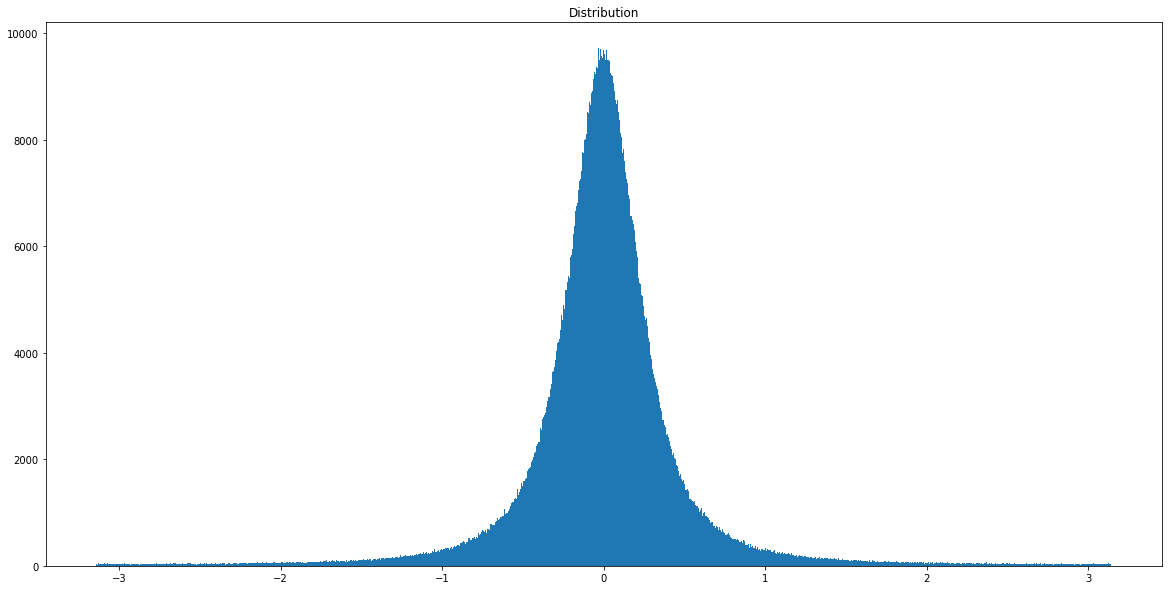

In [24]:
n = generate_noise(1000,1000)

bins = np.linspace(-math.pi, math.pi, 1000)

plt.title("Distribution")
plt.hist(n.flatten(),bins)
plt.show()

## Generate Sample

In [25]:
wavelength=0.6328 # - um
z=15.503 # - um
dx=4.24 # - um
dy=4.24 # - um

a=88.51 # deg
b=88.51 # deg

In [26]:
filename = 'gestalt-theory-wwf-panda-logo.jpg'
#filename = 'MATLAB_0003.avi_frame0.tif'
#filename = '00ae65c1c6631ae6f2be1a449902976e6eb8483bf6b0740d00530220832c6d3e.png'
filename = '0d098413-6911-4535-b70a-3c3effd8cf49.png'
filename = '4.TIF'

input_folder = "I:\\Honours-Project\\data\\simulation\\obj\\"
clean_output_folder = "I:\\Honours-Project\\data\\simulation\\clean_hologram\\"
noisy_output_folder = "I:\\Honours-Project\\data\\simulation\\noisy_hologram\\"

In [27]:
def hologram_image_from_path(filename,subdir="",output_sub_folder="",noisy_wave=False,noisy_obj=False,show_img=True,save_img=False,compress=1):
    img = cv2.imread(f'{input_folder}{subdir}\\{filename}')
    
    if len(img.shape) > 2:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    return hologram_image(img,filename,subdir,output_sub_folder,noisy_wave=noisy_wave,noisy_obj=noisy_obj,show_img=show_img,save_img=save_img,compress=compress)
    
def hologram_image(img,filename,subdir="",output_sub_folder="",noisy_wave=False,noisy_obj=False,show_img=True,save_img=False,compress=1):
    if img is None:
        print(f'{input_folder}{subdir}{filename}' + "is None")
        return None
    
    if len(img.shape) > 2:
        img = np.reshape(img,(img.shape[0],img.shape[1]))

        
    gray = img
    #gray = (gray-np.min(gray))/(np.max(gray)-np.min(gray)) * math.pi
    
    x,y = gray.shape
    
    #obj = np.cos(gray)+1j*np.sin(gray) # Create object with the same real and imaginary values
    #obj = np.multiply(gray,obj)
    #obj = np.ones((x,y))+(1j*gray) # Create object with the same real and imaginary values
    
    phase = (gray-np.min(gray))/(np.max(gray)-np.min(gray)) * math.pi * -5
    
    #phase = np.zeros((x,y))
    
    obj = (np.cos(phase)+1j*np.sin(phase)) * phase # Create object with the same real and imaginary values
    #obj = np.multiply(phase*2/math.pi,obj)
    
    #obj = np.ones((x,y)) + 1j*phase

    real, imaginary = gen_plane_wave(wavelength,dx,dy,a,b,x,y,noisy_wave)
    
    plane_wave = real + 1j*imaginary

    if noisy_obj:
        noise = gen_noise_random_size(int(x/compress),int(y/compress))
        
        noise = np.repeat(np.repeat(noise,compress,axis=0),compress,axis=1)
                
        # object_wave = object_propogation(obj,wavelength,z,dx,dy,noisy=noise)
        #obj = np.cos(phase+noise) + 1j*np.sin(phase+noise)
        obj = (np.cos(phase+noise) + 1j*np.sin(phase+noise))*((phase/5)+noise)
        object_wave = object_propogation(obj,wavelength,z,dx,dy,noisy=None)
    else:
        object_wave = object_propogation(obj,wavelength,z,dx,dy,noisy=None)
    
    comb_wave = (plane_wave) + (object_wave)
    
    #no_amp = np.ones((x,y)) + np.angle(comb_wave)
    #plane = np.angle(plane_wave + plane_wave) + np.ones((x,y))

    inten = intensity(comb_wave)
    
    print(np.min(inten))
    print(np.min(intensity(plane_wave)))
    print(np.min(intensity(object_wave)))
    
    print(np.max(inten))
    print(np.max(intensity(object_wave)))
    print(np.max(intensity(plane_wave)))
    
    #ccc1 = np.power(np.abs(plane_wave),2) + np.power((np.abs(plane_wave))**2,2) + np.multiply((np.conj(plane_wave)),(plane_wave)) + np.multiply((plane_wave),(np.conj(plane_wave)))
    
    #print(ccc1)
    
    if show_img:
        if noisy_obj:
            plt.imshow(inten)
            
            fft = np.log(np.abs(np.fft.fftshift(np.fft.fft2(inten))+1))
            
            #sp.misc.imsave(f'output_noisy_{noise_dist.mu}_new_phase{max_speckle_size}_noise_{noise_mult_neg}_{noise_mult_pos}.png',np.angle(object_wave))
            #sp.misc.imsave(f'output_noisy_{noise_dist.mu}_new_comp{max_speckle_size}_noise_{noise_mult_neg}_{noise_mult_pos}.png',inten) 
            #sp.misc.imsave(f'output_noisy_{noise_dist.mu}_new_comp{max_speckle_size}_noise_noise_{noise_mult_neg}_{noise_mult_pos}.png',noise)
            #sp.misc.imsave(f'output_noisy_{noise_dist.mu}_new_comp{max_speckle_size}_fft_noise_{noise_mult_neg}_{noise_mult_pos}.png',fft)
        else:
            plt.imshow(inten)
    
    if save_img:
        if noisy_wave:
            np.save(f'{noisy_output_folder}{output_sub_folder}\\{filename}',inten)
        else:
            np.save(f'{clean_output_folder}{output_sub_folder}\\{filename}',inten)
    
    return inten

2.4243614842356842e-05
0.9999999999999998
0.00014038088988898721
308.8976873350197
281.3229747571608
1.0


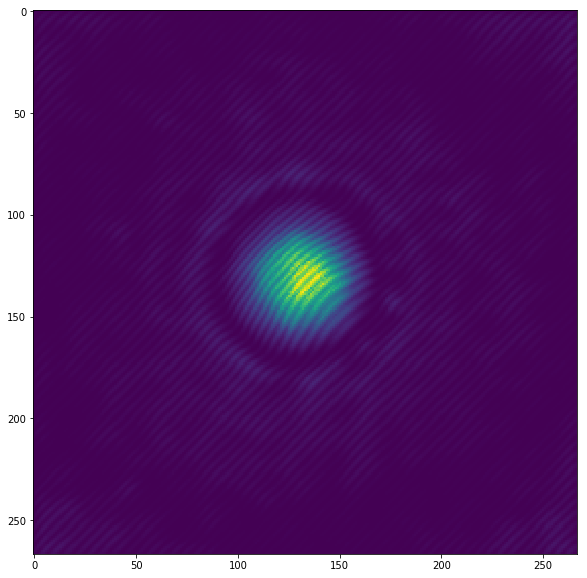

In [28]:
img = hologram_image_from_path(filename,save_img=False,show_img=True)

In [33]:
sp.misc.imsave("noisy_bead.png",img)

C:\Users\Duo\Anaconda3\envs\fastai\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.
  """Entry point for launching an IPython kernel.


0.00010673184402731407
0.9999999999999998
3.0514555706684734e-07
47.42119238657434
36.529965719611745
1.0


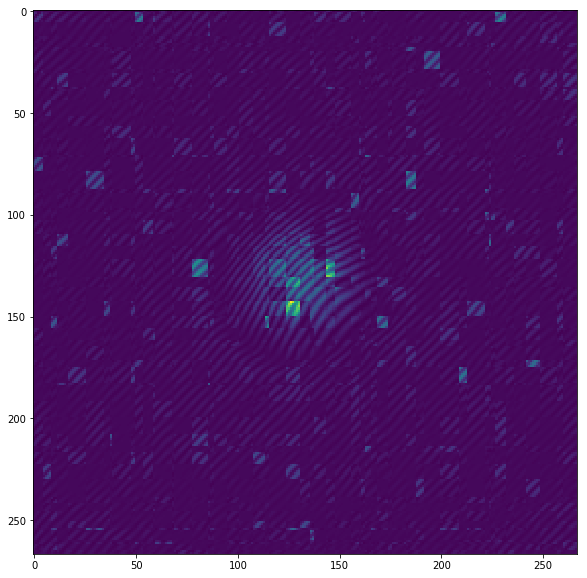

In [34]:
img = hologram_image_from_path(filename,noisy_obj=True,show_img=True,save_img=False)

In [ ]:
ma = np.max(img)
mi = np.min(img)
print(ma)
print(mi)
print((ma-mi)/(ma+mi))

In [ ]:
img = hologram_image_from_path(filename,noisy_wave=True,noisy_obj=True,show_img=True,save_img=False)

In [ ]:
i = cv2.imread(f'{input_folder}\\malaria\\malaria\\images\\d12c5f45-6b20-46d6-a66f-c5a4683c25b3.png')
#i = cv2.imread(f'{input_folder}\\malaria\\malaria\\images\\0d3c2521-da55-4df5-bf06-56b3bd4fb2fc.png')
print(i)
plt.imshow(i)

In [ ]:
img = np.ones((500,500))
img = hologram_image(img,filename=None,subdir="",output_sub_folder="",noisy_wave=False,noisy_obj=True,show_img=True,save_img=False)

In [95]:
#sp.misc.imsave('output_clean_phase_only_88_83.png',img)
sp.misc.imsave(f'output_water_4_1000.png',img)

C:\Users\Duo\Anaconda3\envs\fastai\lib\site-packages\ipykernel_launcher.py:2: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.
  


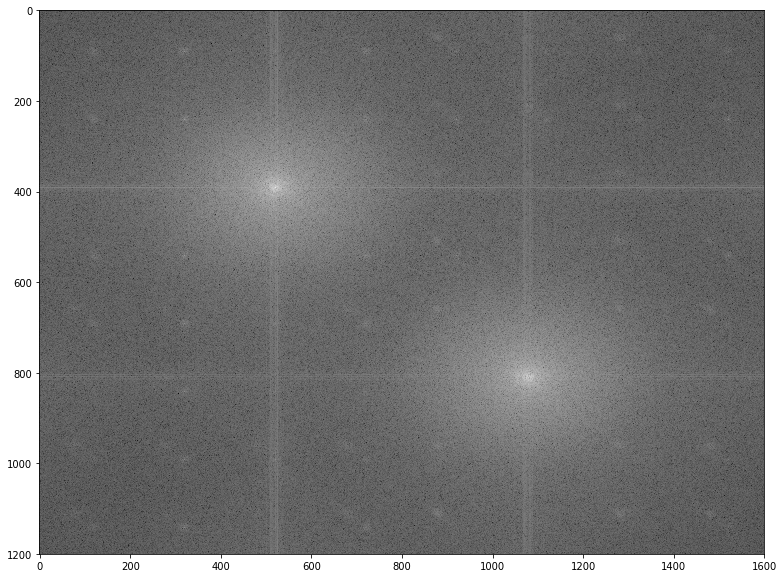

In [23]:
plt.imshow(np.log(np.abs(np.fft.fftshift(np.fft.fft2(img))+1)),cmap=plt.cm.gray)

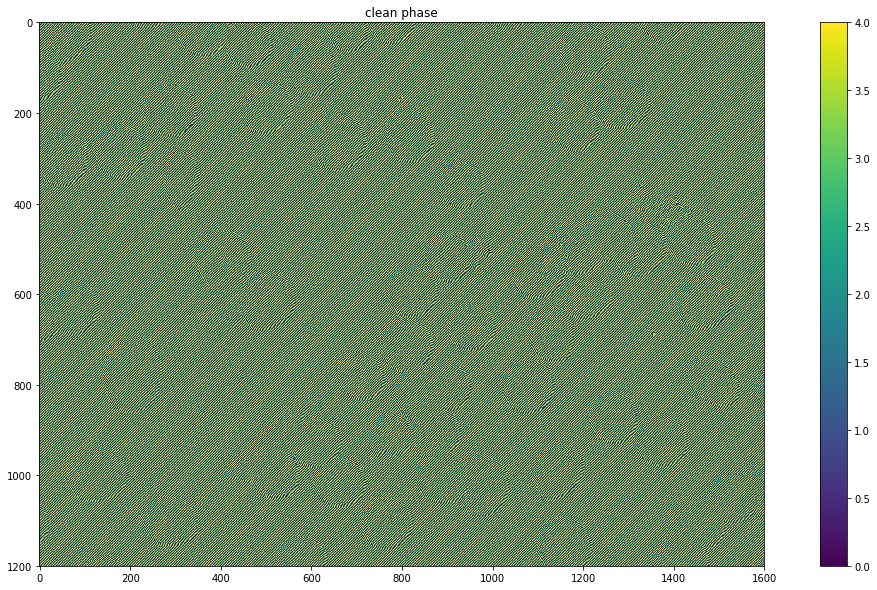

In [33]:
fft = np.fft.fft2(img)
ifft = np.fft.ifft2(fft)

#print(img-ifft)
#plt.imshow(np.angle(ifft))
#plt.imshow(np.angle(img))


fig,ax = plt.subplots(1,1)

ax.set_title("clean phase")
bax = ax.imshow(np.abs(ifft))
bbar = fig.colorbar(bax,ax=ax)


## Compress Tests

In [399]:
compress = 8

## Convert all images

In [28]:
accepted_file_extensions = ['.tif','.png','.TIF','.jpg']

In [78]:
for file in os.listdir(input_folder):
    hologram_image_from_path(file,show_img=False,save_img=True)

In [79]:
for file in os.listdir(input_folder):
    hologram_image_from_path(file,noisy_wave=True,show_img=False,save_img=True)

In [29]:
for subdir, dirs, files in os.walk(input_folder):
    for file in files:
        filename, file_extension = os.path.splitext(file)
        
        if "masks" in subdir:
            continue
            
        if file_extension in accepted_file_extensions:
            sdir = subdir.replace(input_folder,"")
            hologram_image_from_path(file,subdir=sdir,show_img=False,save_img=True)

KeyboardInterrupt: 

In [17]:
for subdir, dirs, files in os.walk(input_folder):
    for file in files:
        filename, file_extension = os.path.splitext(file)
        
        if "masks" in subdir:
            continue
            
        if file_extension in accepted_file_extensions:
            
            if f'{file}.npy' in os.listdir(noisy_output_folder):
                continue
            
            print("Creating hologram of " + filename)
            sdir = subdir.replace(input_folder,"")
            hologram_image_from_path(file,subdir=sdir,noisy_wave=True,show_img=False,save_img=True)

Creating hologram of 6b6d4e6ff52de473a4b6f8bd0f11ae22242d508cc4117ff38ec39cbb88088aaa
Creating hologram of 6b72b61b80060a9e79a4747f9c5d5af135af9db466681c2d1086f784c7130699
Creating hologram of 6bc8cda54f5b66a2a27d962ac219f8075bf7cc43b87ba0c9e776404370429e80
Creating hologram of 6bd18a218d25247dc456aed124c066a6397fb93086e860e4d04014bfa9c9555d
Creating hologram of 6bd330234b763b77796d4804de8e224881c0fc8dd02650fa708b2edfd8c7461f
Creating hologram of 6c67b78e8164801059375ed9a607f61e67a7ae347e92e36a7f20514224541d56
Creating hologram of 6c85029f850d392791e13f74963391054ff54e508967bbd091ee510e9e58e011
Creating hologram of 6d327ab4f0e3604fa6e9b8041c7e6db86ab809890d886c691f6e59c9168b7fbe
Creating hologram of 6eefe1f0d9c2d2c2380db3ecd2113a566ace7dfc917687bb5033b4af5b8293aa
Creating hologram of 6f8197baf738986a1ec3b6ba92b567863d897a739376b7cec5599ad6cecafdfc
Creating hologram of 6fb82031f7fc5f4fa6e0bc2ef3421db19036b5c2cdd2725009ab465d66d61d72
Creating hologram of 6fc83b33896f58a4a067d8fdcf51f15d4

Creating hologram of 91cc2e0d4d6e2c1ad59a8d63bcbe3e2ea8bc7f8e642e942a0113450181e73379
Creating hologram of 92e7e86e765e05ce331c07a6d14f0a696eac7ee40058699243900f40b696d7aa
Creating hologram of 92f31f591929a30e4309ab75185c96ff4314ce0a7ead2ed2c2171897ad1da0c7
Creating hologram of 930f246a8e4ff273a72a6e4b3cf8e8caff94fca4eaf1dbe6f93ba37b8195c0a0
Creating hologram of 93c5638e7e6433b5c9cc87c152bcbe28873d2f9d6a392cca0642520807542a77
Creating hologram of 93cfd412c7de5210bbd262ec3a602cfea65072e9272e9fce9b5339a5b9436eb7
Creating hologram of 942d56861fc83e195e9c559a000bb86627d8682f8dcc2300818458e5b6850dd0
Creating hologram of 94519eb45cbe1573252623b7ea06a8b43c19c930f5c9b685edb639d0db719ab0
Creating hologram of 947c0d94c8213ac7aaa41c4efc95d854246550298259cf1bb489654d0e969050
Creating hologram of 94a5a37c3b1153d5c5aef2eca53c960b9f21f2ef1758209d7ec502ec324b03a3
Creating hologram of 9520aff4efe87bd8f3901652fa2dde9b4bc9c679325966145ce00c1ca33f35de
Creating hologram of 953211bcc0192e2298087d30e708dba68

Creating hologram of b1eb0123fe2d8c825694b193efb7b923d95effac9558ee4eaf3116374c2c94fe
Creating hologram of b1f23c4d27afed8af7b6b64793a3760bfea31b65f582d48aaa62d2b988ef2eac
Creating hologram of b214800de5ed4cc558f44d569495970f93c8c047f8e464c51d4bd5c276118423
Creating hologram of b24ea5c268469a95ed155eeaf809e36030b78a2eb530a0cb2380cdc1ccdb7dd1
Creating hologram of b2c23ddb04531158da6a0abcaca78fec0ae5c6f64f60166e4f36f4a161efd76f
Creating hologram of b2c5d8653c621207e97b699e5c4c05d13df4f02d9db3e594b1f0c22e5b746aae
Creating hologram of b3a9f4c9035a0df7e033b18c63bfb0f0d87ff5a4d9aa8bdf417159bb733abb80
Creating hologram of b3b1626f8ad156acb2963d1faa6a368f9378a266c3b90d9321087fdc5b3032b4
Creating hologram of b3bfd873fca7ff9b2e90f507dfdbe165bb8c153399b6ba5829aa59bae677a91d
Creating hologram of b4d902d42c93dea77b541456f8d905f35eeb24fc3a5b0b15b5678d78e0aabe0c
Creating hologram of b4de1e3eec159d8af1bd5447696f8996c31709edaf33e26ba9613816705847db
Creating hologram of b560dba92fbf2af785739efced50d5866

Creating hologram of d6eb7ce7723e2f6dc13b90b41a29ded27dbd815bad633fdf582447c686018896
Creating hologram of d751ccb64fa767a65a966061218438bd1860695d96bbef11fdb2f0d3b8dedba8
Creating hologram of d7d12a2acc47a94961aeb56fd56e8a0873016af75f5dd10915de9db8af8e4f5e
Creating hologram of d7db360fabfce9828559a21f6bffff589ae868e0dc6101d7c1212de34a25e3cb
Creating hologram of d7ec8003735996458b56ccb8ae34d080eb2a6adabef931323239632515b4b220
Creating hologram of d7fc0d0a7339211f2433829c6553b762e2b9ef82cfe218d58ecae6643fa8e9c7
Creating hologram of d827a7d80fc67487a3237135e0d43ae01b7bbcb135e1a167601fc974a8348c51
Creating hologram of d8607b21411c9c8ab532faaeba15f8818a92025897950f94ee4da4f74f53660a
Creating hologram of d8d4bf68a76e4e4c5f21de7ac613451f7115a04db686151e78b8ec0b6a22022b
Creating hologram of d910b2b1be8406caecfe31a503d412ffc4e3d488286242ebc7381836121dd4ef
Creating hologram of da31f2aa8601afec5c45180a2c448cb9c4a8ec7b35e75190d6ba3588f69058c8
Creating hologram of da5f98f2b8a64eee735a398de48ed42cd

Creating hologram of f81ca7ee25e733ff37240c34c8e3044d9937bb0166e315952ebde3f237ecb86f
Creating hologram of f8e74d4006dd68c1dbe68df7be905835e00d8ba4916f3b18884509a15fdc0b55
Creating hologram of f93ec5e683d81005ffc2a84a1c0299b2406ad14b764b824e013f7ca3a13833b5
Creating hologram of f952cc65376009cfad8249e53b9b2c0daaa3553e897096337d143c625c2df886
Creating hologram of f9ac03b0344ce8c48bc058448541f9211a1e5f4c94fdaf633dd534328d8610ab
Creating hologram of f9ea1a1159c33f39bbe5f18bb278d961188b40508277eab7c0b4b91219b37b5d
Creating hologram of fa73f24532b3667718ede7ac5c2e24ad7d3cae17b0a42ed17bbb81b15c28f4ae
Creating hologram of fa751ff3a6332c95cb5cb1d28563553914295e9e7d35c4b6bd267241e8a0787c
Creating hologram of fac507fa4d1649e8b24c195d990f1fc3ca3633d917839e1751a9d412a14ab5e3
Creating hologram of fadeb0ab092833f27daaeb3e24223eb090f9536b83f68cde8f49df7c544f711b
Creating hologram of fc22db33a2495f58f118bc182c0087e140df14ccb8dad51373e1a54381f683de
Creating hologram of fc345dac2205deb169bd70197f07f053b

## Malaria Dataset

In [31]:
def create_hologram(noisy=False):
    for subdir, dirs, files in os.walk(f'{input_folder}\\malaria'):
        for file in files:
            filename, file_extension = os.path.splitext(file)

            if "masks" in subdir:
                continue

            if file_extension in accepted_file_extensions:
                sdir = subdir.replace(input_folder,"")
                hologram_image_from_path(file,subdir=sdir,output_sub_folder="malaria\\89\\",noisy_wave=noisy,show_img=False,save_img=True)

In [32]:
create_hologram(noisy=False)

AttributeError: 'NoneType' object has no attribute 'shape'

In [ ]:
create_hologram(noisy=True)

## MNIST

In [155]:
(x_train, _), (x_test, _) = mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = np.reshape(x_train, (len(x_train), 28, 28, 1))  # adapt this if using `channels_first` image data format
x_test = np.reshape(x_test, (len(x_test), 28, 28, 1))  # adapt this if using `channels_first` image data format

mnist_folder = "mnist\\"

x_train_hologram = []
x_test_hologram = []

print(x_train.shape)

for index in range(x_train.shape[0]):
    img = x_train[index]
    x_train_hologram.append(hologram_image(img=img,filename=f'train_{index}',
                                                             output_sub_folder=mnist_folder,
                                                             noisy_wave=False,show_img=False,save_img=False))

for index in range(x_test.shape[0]):
    img = x_test[index]
    x_test_hologram.append(hologram_image(img=img,filename=f'test_{index}',
                                                             output_sub_folder=mnist_folder,
                                                             noisy_wave=False,show_img=False,save_img=False))
    
x_train_hologram = np.asarray(x_train_hologram)
x_test_hologram = np.asarray(x_test_hologram)

np.save(f'{clean_output_folder}mnist_train',x_train_hologram)
np.save(f'{clean_output_folder}mnist_test',x_test_hologram)

print(x_train_hologram.shape)

(60000, 28, 28, 1)
(60000, 28, 28)


In [ ]:
(x_train, _), (x_test, _) = mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = np.reshape(x_train, (len(x_train), 28, 28, 1))  # adapt this if using `channels_first` image data format
x_test = np.reshape(x_test, (len(x_test), 28, 28, 1))  # adapt this if using `channels_first` image data format

mnist_folder = "mnist\\"

x_train_hologram = []
x_test_hologram = []

print(x_train.shape)

for index in range(x_train.shape[0]):
    img = x_train[index]
    x_train_hologram.append(hologram_image(img=img,filename=f'train_{index}',
                                                             output_sub_folder=mnist_folder,
                                                             noisy_wave=True,show_img=False,save_img=False))

for index in range(x_test.shape[0]):
    img = x_test[index]
    x_test_hologram.append(hologram_image(img=img,filename=f'test_{index}',
                                                             output_sub_folder=mnist_folder,
                                                             noisy_wave=True,show_img=False,save_img=False))
    
x_train_hologram = np.asarray(x_train_hologram)
x_test_hologram = np.asarray(x_test_hologram)

np.save(f'{noisy_output_folder}mnist_train',x_train_hologram)
np.save(f'{noisy_output_folder}mnist_test',x_test_hologram)

print(x_train_hologram.shape)

(60000, 28, 28, 1)
